In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astropy_healpix as ah
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u

from ligo.skymap.io import fits
from ligo.skymap import plot, postprocess  # Adjust import path as needed

import astropy_healpix as ah

import h5py as h 
import glob

from matplotlib import rcParams
size=20


ggplot_styles = {
    'axes.titlesize': size,
    'axes.labelsize': size,
    'xtick.labelsize': size,
    'ytick.labelsize': size,
    'legend.fontsize': size,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.family': 'serif',
    'font.serif': ['serif'],
}
plt.rcParams.update(ggplot_styles)

In [7]:
injection = h.File('../../injections/injections_500mpc_with_theta_jn.hdf','r')
event_mask = np.isclose(injection['distance'][:], 361.23, rtol=1e-3)
event_ra = np.degrees(injection['ra'][event_mask])
event_dec = np.degrees(injection['dec'][event_mask])

print (injection['distance'][event_mask])
print (injection['inclination'][event_mask])
print (np.degrees(injection['inclination'][event_mask]))

[361.23323861]
[2.69429606]
[154.37179314]


In [3]:


def plot_skymap(input_fits,
                projection='mollweide',
                contour_levels=None,
                annotate=False,
                colorbar=False,
                radec_points=None,
                inj_database=None,
                geo=False,
                projection_center=None,
                zoom_radius=None,
                add_inset=False,
                input_title=None,
                output=None):
    """
    Plot a gravitational-wave sky map from a FITS file.
    """
    skymap, metadata = fits.read_sky_map(input_fits, nest=None)
    nside = ah.npix_to_nside(len(skymap))
    deg2perpix = ah.nside_to_pixel_area(nside).to_value(u.deg**2)
    probperdeg2 = skymap / deg2perpix

    plt.figure(figsize=(15,8)) 

    axes_args = {}
    if geo:
        axes_args['projection'] = 'geo'
        obstime = Time(metadata['gps_time'], format='gps').utc.isot
        axes_args['obstime'] = obstime
    else:
        axes_args['projection'] = 'astro'
    axes_args['projection'] += ' ' + projection
    if projection_center is not None:
        axes_args['center'] = SkyCoord(projection_center)
    if zoom_radius is not None:
        axes_args['radius'] = zoom_radius

    ax = plt.axes(**axes_args)
    ax.grid()

    vmax = probperdeg2.max()
    img = ax.imshow_hpx((probperdeg2, 'ICRS'),
                        nested=metadata['nest'], vmin=0., vmax=vmax,cmap='cylon',)

    if colorbar:
        cb = plot.colorbar(img)
        cb.set_label(r'Probability per deg$^2$')

    if contour_levels:
        cls = 100 * postprocess.find_greedy_credible_levels(skymap)
        cs = ax.contour_hpx(
            (cls, 'ICRS'), nested=metadata['nest'],
            colors='k', linewidths=0.5, levels=contour_levels)
        fmt = r'%g\%%' if rcParams['text.usetex'] else '%g%%'
        plt.clabel(cs, fmt=fmt, fontsize=18, inline=True)

    if geo:
        plt.plot(*plot.coastlines(), color='0.5', linewidth=0.5,
                 transform=ax.get_transform('world'))

    plt.title(input_title, fontsize=size)
    
    if radec_points:
        for ra, dec in radec_points:
            ax.plot_coord(
                SkyCoord(ra, dec, unit='deg'), '*',
                markerfacecolor='white', markeredgecolor='black',
                markersize=10)

        if add_inset and radec_points:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes
            from matplotlib.patches import ConnectionPatch

            ra0, dec0 = radec_points[0]
            coord_center = SkyCoord(ra0, dec0, unit='deg')
            inset_radius = '5 deg'
            fig = ax.get_figure()

            # Create inset axis
            inset_box = [0.78, 0.25, 0.18, 0.35]  # [left, bottom, width, height]
            inset_ax = fig.add_axes(
                inset_box,
                projection='astro zoom',
                center=coord_center,
                radius=inset_radius
            )

            inset_ax.grid()

            inset_img = inset_ax.imshow_hpx(
                        (probperdeg2, 'ICRS'),  
                        nested=metadata['nest'],
                        vmin=0,
                        vmax=vmax,
                        rasterized=True,
                        cmap='cylon'
                    )

            if contour_levels:
                cls = 100 * postprocess.find_greedy_credible_levels(skymap)
                inset_ax.contour_hpx(
                    (cls, 'ICRS'),
                    nested=metadata['nest'],
                    colors='white',
                    linewidths=1.0,
                    levels=contour_levels
                )

            inset_ax.plot_coord(
                coord_center,
                marker='*',
                color='white',
                markeredgecolor='black',
                markersize=10,
                zorder=100
            )
            inset_ax.set_xticks([])
            inset_ax.set_yticks([])
            inset_ax.set_title('Zoom-in', fontsize=size)

            # Draw connecting arrows from main map to inset
            con1 = ConnectionPatch(
                xyA=(ra0, dec0), coordsA=ax.get_transform('icrs'),
                xyB=(0.5, 0.5), coordsB=inset_ax.transAxes,
                arrowstyle="->", color='gray', linewidth=1.2
            )
            con2 = ConnectionPatch(
                xyA=(ra0, dec0), coordsA=ax.get_transform('icrs'),
                xyB=(0.2, 0.8), coordsB=inset_ax.transAxes,
                arrowstyle="->", color='gray', linewidth=1.2
            )
            fig.add_artist(con1)
            fig.add_artist(con2)

    plot.outline_text(ax)

    if annotate:
        text = []
        if contour_levels:
            pp = np.round(contour_levels).astype(int)
            ii = np.round(np.searchsorted(np.sort(cls), contour_levels) *
                          deg2perpix).astype(int)
                       
            print (f'{input_title} Areas:', ii, pp)
            area_str = f"{ii[0]:,}" if ii[0] >= 100000 else f"{ii[0]}"
            text.append(rf"{pp[0]:.0f}\% area: {area_str} deg$^2$")
            ax.text(1, 1.05, '\n'.join(text), transform=ax.transAxes, ha='right', va='top', fontsize=size)

    
    plt.savefig(f"{output}.pdf", format='pdf', bbox_inches='tight')


    return ax  

L Areas: [24219] [90]
HL Areas: [658] [90]
HLV Areas: [75] [90]
HLVK Areas: [47] [90]
HLA Areas: [9] [90]
HLVA Areas: [9] [90]
HLVAK Areas: [8] [90]


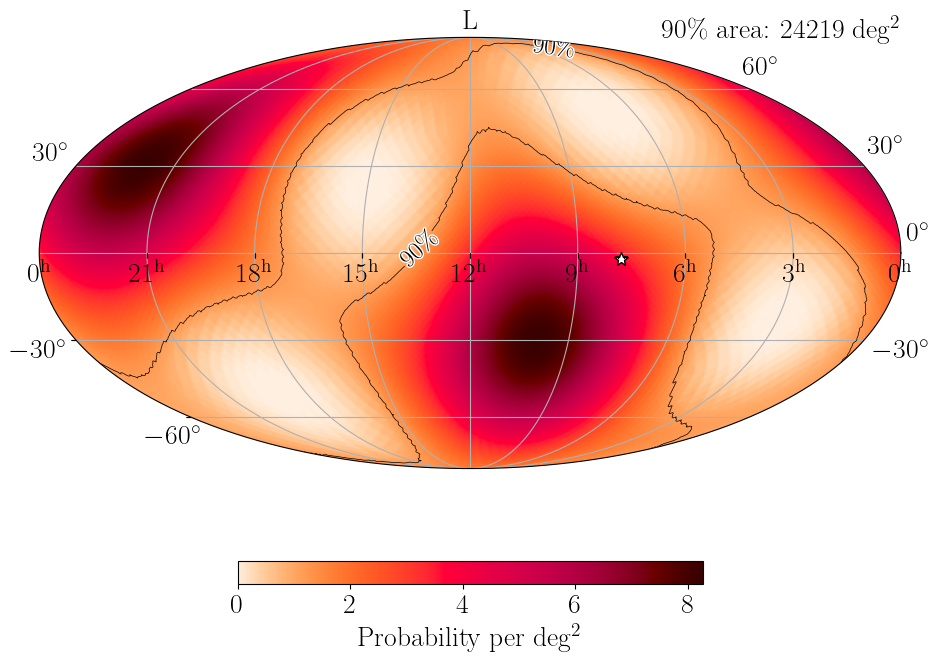

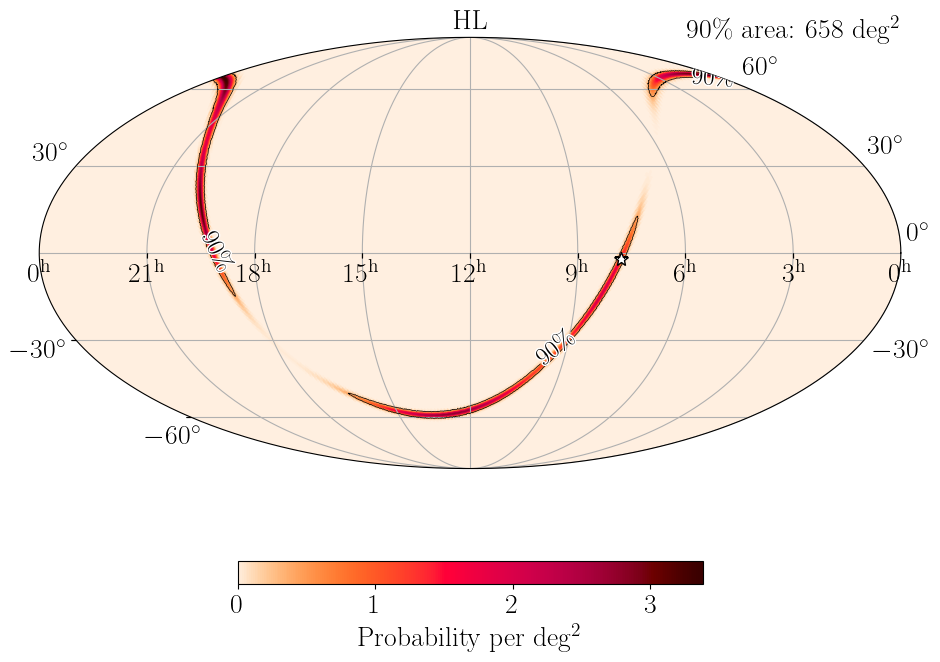

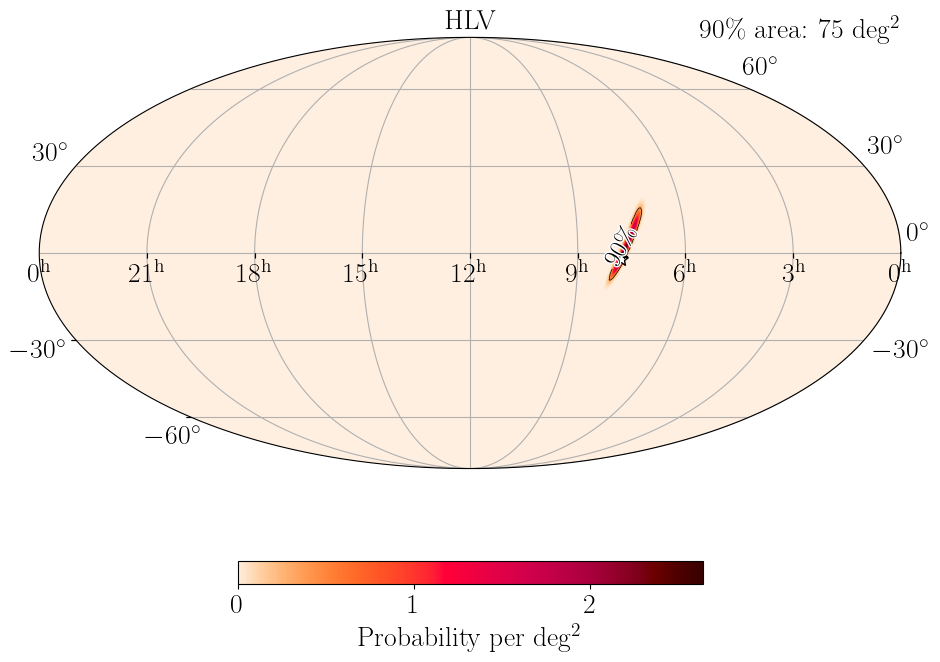

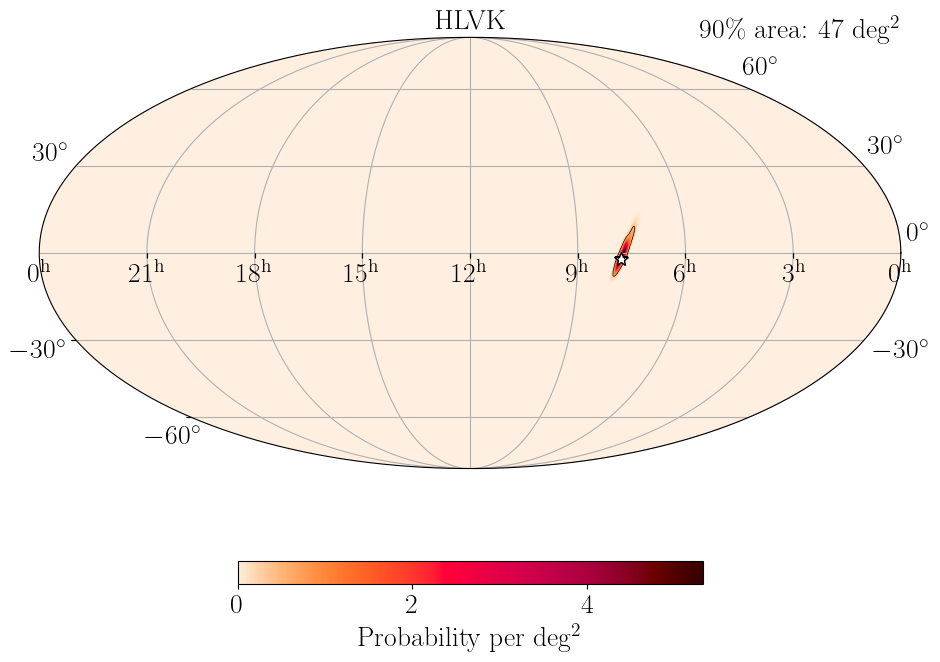

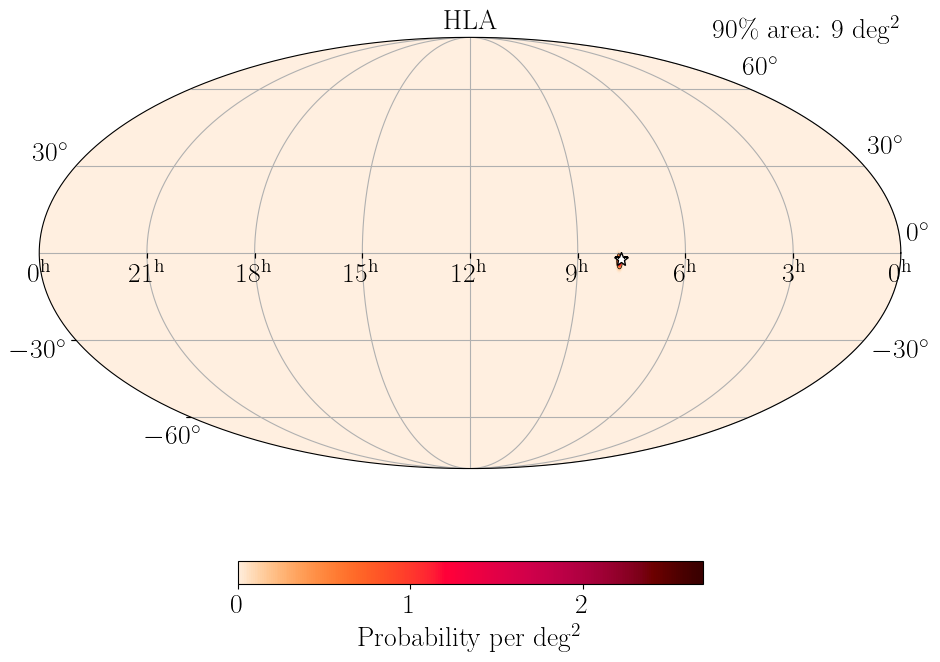

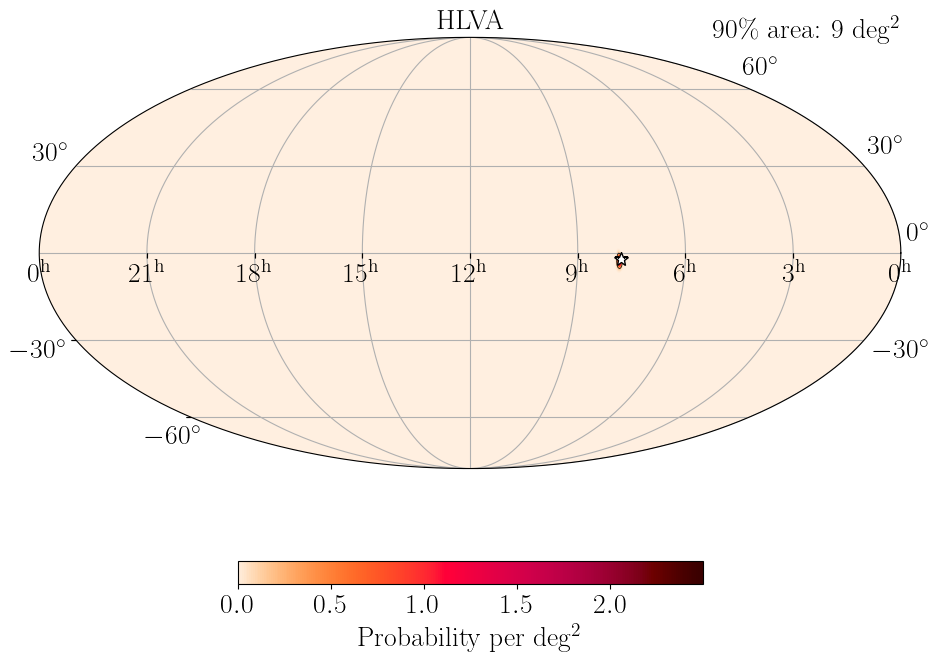

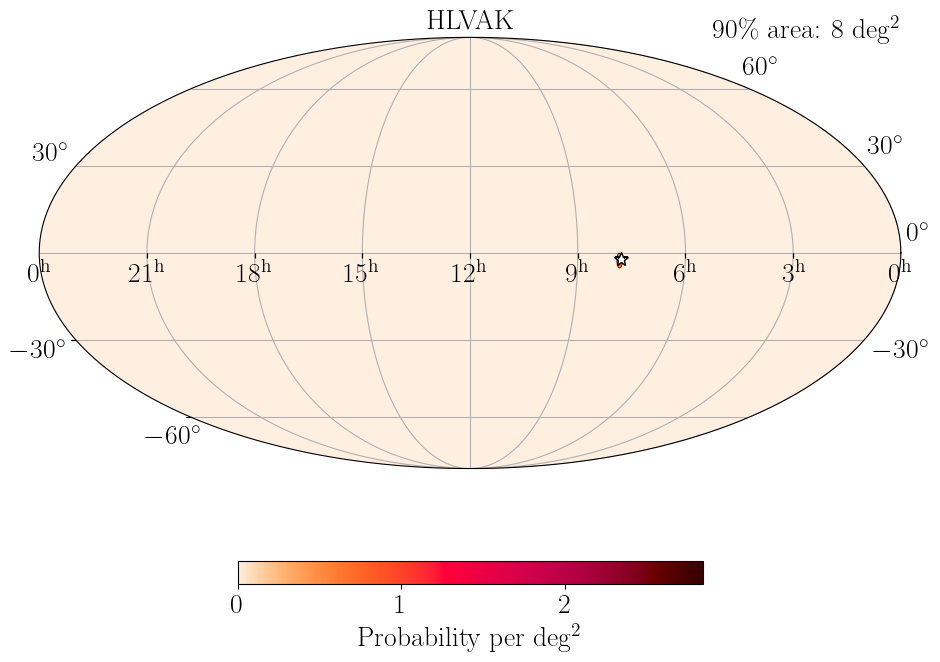

In [4]:
fits_files = {
    "L": glob.glob('coinc-1365948658.8011718-xzwiyh_L.fits/*')[0],
    "HL": glob.glob('coinc-1365948658.8011718-xzwiyh_HL.fits/*')[0],
    "HLV": glob.glob('coinc-1365948658.8011718-xzwiyh_HLV.fits/*')[0],
    "HLVK": glob.glob('coinc-1365948658.8011718-xzwiyh_HLVK.fits/*')[0],
    "HLA": glob.glob('coinc-1365948658.8011718-xzwiyh_HLI.fits/*')[0],
    "HLVA": glob.glob('coinc-1365948658.8011718-xzwiyh_HLVI.fits/*')[0], 
    "HLVAK": glob.glob('coinc-1365948658.8011718-xzwiyh_HLVIK.fits/*')[0],
}

for label, fits_file in fits_files.items():
    plot_skymap(
        fits_file,
        contour_levels=[90],
        annotate=True,
        radec_points=[(event_ra[0], event_dec[0])],
        colorbar=True,
        add_inset=False,
        input_title=label,
        output=f"skymap_{label}"
    )

HLA Areas: [9] [90]


<AstroMollweideAxes: title={'center': 'HLA'}>

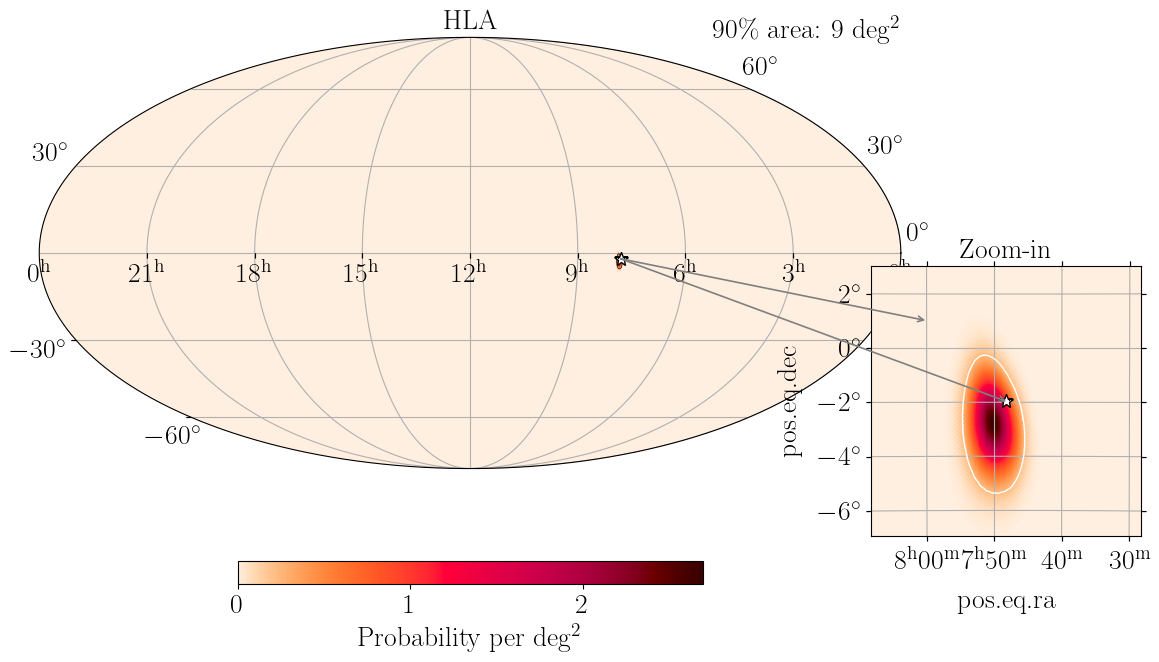

In [4]:
plot_skymap(
        glob.glob('coinc-1365948658.8011718-xzwiyh_HLI.fits/*')[0],
        contour_levels=[90],
        annotate=True,
        radec_points=[(event_ra[0], event_dec[0])],
        colorbar=True,
        add_inset=True,
        input_title="HLA", 
        output=f"skymap_HLA_inset")